In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

import folium as g
#플롯에서 한글이 깨지는 경우가 없도록 폰트 지정
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [51]:
scaler = MinMaxScaler()

df = pd.read_csv('회귀분석_Lasso기반 청년인프라지수.csv', encoding='cp949')

df = df.drop('Unnamed: 0',axis=1)
df.set_index('시군구', inplace=True)

#시군구 위경도 데이터 불러오기
df_loc = pd.read_csv('시군구_위경도.csv', encoding='cp949')
df_loc = df_loc.drop(['Unnamed: 4'], axis = 1) #비어있는 열 제거 

df_loc = df_loc.loc[0:74] #세종까지 행을 자름
df_loc = df_loc.set_index('name') # 인덱스를 시군구로 지정

#위경도를 붙어줌
df_loc_merge = df.join(df_loc, how='left')
df_loc_merge

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,id,lat,lon
시군구,,,,,,,,,,,,,,,,,,,,
서울_종로구,32943.0,496,28.0,3,60.0,0,1,23,5730,24,201,0,19.0,0.0,367.0,0.0,2.597156,11110.0,37.594920,126.977317
서울_중구,28277.0,572,16.0,2,48.0,0,1,17,5383,62,281,1,18.0,0.0,77.0,0.0,1.991037,11140.0,37.560143,126.995968
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,6.336887,11170.0,37.531386,126.979908
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,5.511858,11200.0,37.551030,127.041059
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,6.133916,11215.0,37.546722,127.085746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,4.040873,31140.0,35.516052,129.328190
울산_동구,26280.0,174,18.0,1,60.0,0,1,5,3107,3,71,0,10.0,0.0,4.0,0.0,5.464600,31170.0,35.525580,129.426070
울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,8.043699,31200.0,35.610062,129.379802


In [52]:
#df_loc_merge.to_csv("이상치 제거 전.csv", encoding="cp949")

In [53]:
def get_outlier(df, column, weight=1.5):
    # 이상치가 있는 index 반환
    
    # 1/4분위와 3/4분위 지점 지정
    quantile_25 = np.percentile(df[column].values, 25) #Q1
    quantile_75 = np.percentile(df[column].values, 75) #Q3
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
    
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고, index 반환
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    
    return outlier_idx
#linear 데이터
outlier_linear_idx1 = get_outlier(df_loc_merge, '병원')
print("이상치 데이터 index1: ", outlier_linear_idx1)

outlier_linear_idx2 = get_outlier(df_loc_merge, '사회스포츠')
print("이상치 데이터 index2: ", outlier_linear_idx2)

outlier_linear_idx3 = get_outlier(df_loc_merge, '경찰서')
print("이상치 데이터 index3: ", outlier_linear_idx3)

outlier_linear_idx4 = get_outlier(df_loc_merge, '소형상업시설(음식점_카페_학원_편의점)')
print("이상치 데이터 index4: ", outlier_linear_idx4)

outlier_linear_idx5 = get_outlier(df_loc_merge, '대형상업시설')
print("이상치 데이터 index5: ", outlier_linear_idx5)

이상치 데이터 index1:  Index(['서울_서초구', '서울_강남구', '서울_송파구'], dtype='object', name='시군구')
이상치 데이터 index2:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index3:  Index(['서울_종로구'], dtype='object', name='시군구')
이상치 데이터 index4:  Index(['서울_강남구'], dtype='object', name='시군구')
이상치 데이터 index5:  Index(['서울_중구'], dtype='object', name='시군구')


In [54]:
df_copy = df_loc_merge.copy() #데이터 복사

df_copy.drop(outlier_linear_idx1, axis=0, inplace=True)
df_copy.drop(outlier_linear_idx3, axis=0, inplace=True)
df_copy.drop(outlier_linear_idx5, axis=0, inplace=True)

df_copy = df_copy.drop(['인천_옹진군']) # 인프라지수가 -18인 특이값 제거
df_copy

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,id,lat,lon
시군구,,,,,,,,,,,,,,,,,,,,
서울_용산구,52554.0,319,19.0,1,47.0,0,1,9,5056,23,104,9,18.0,1.0,48.0,0.0,6.336887,11170.0,37.531386,126.979908
서울_성동구,67271.0,457,21.0,2,69.0,0,1,10,4562,22,62,3,19.0,0.0,31.0,0.0,5.511858,11200.0,37.551030,127.041059
서울_광진구,91126.0,558,76.0,3,76.0,0,1,12,5609,26,66,0,17.0,0.0,25.0,1.0,6.133916,11215.0,37.546722,127.085746
서울_동대문구,80217.0,597,43.0,4,76.0,0,1,12,4902,33,112,7,16.0,0.0,21.0,0.0,5.112107,11230.0,37.581957,127.054848
서울_중랑구,83722.0,539,96.0,1,76.0,0,1,9,4410,14,89,7,18.0,0.0,5.0,1.0,5.865862,11260.0,37.597819,127.092884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
울산_남구,64670.0,618,24.0,1,106.0,0,1,6,7460,16,244,4,16.0,2.0,18.0,3.0,4.040873,31140.0,35.516052,129.328190
울산_동구,26280.0,174,18.0,1,60.0,0,1,5,3107,3,71,0,10.0,0.0,4.0,0.0,5.464600,31170.0,35.525580,129.426070
울산_북구,41455.0,172,30.0,0,94.0,1,1,5,3492,11,52,2,9.0,0.0,9.0,0.0,8.043699,31200.0,35.610062,129.379802


In [228]:
df_copy['청년인프라지수'].mean()

5.1887771907524405

In [6]:
#df_copy.to_csv('인프라지수 정규화전.csv', encoding="cp949")

In [7]:
df_col = df_copy[['청년인프라지수','lat','lon']] #정규화 진행전 빼놓기
df_copy_scale = df_copy.drop(['청년인프라지수','id','lat','lon'], axis=1)

#정규화 진행
df_copy_scale[:] = scaler.fit_transform(df_copy_scale[:])
df_copy_scale.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널
시군구,,,,,,,,,,,,,,,,
서울_용산구,0.300464,0.286774,0.021053,0.166667,0.185393,0.0,0.5,0.500000,0.482898,0.392857,0.282468,1.000000,0.478261,0.25,0.602740,0.00
서울_성동구,0.398784,0.457355,0.031579,0.333333,0.308989,0.0,0.5,0.583333,0.424228,0.375000,0.146104,0.333333,0.521739,0.00,0.369863,0.00
서울_광진구,0.558152,0.582200,0.321053,0.500000,0.348315,0.0,0.5,0.750000,0.548575,0.446429,0.159091,0.000000,0.434783,0.00,0.287671,0.25
서울_동대문구,0.485272,0.630408,0.147368,0.666667,0.348315,0.0,0.5,0.750000,0.464608,0.571429,0.308442,0.777778,0.391304,0.00,0.232877,0.00
서울_중랑구,0.508688,0.558714,0.426316,0.166667,0.348315,0.0,0.5,0.500000,0.406176,0.232143,0.233766,0.777778,0.478261,0.00,0.013699,0.25


In [8]:
#정규화 후 위경도,인프라지수 합쳐주기
df_copy_scale = df_copy_scale.join(df_col, how = 'left')

df_copy_scale.head()

,청년인구,병원,사회스포츠,대학교,초중고,공항,소방서,경찰서,소형상업시설(음식점_카페_학원_편의점),대형상업시설,숙박시설,기차역,행정기관,"법원, 교도소",문화시설_영화/공연/미술관박물관,버스터미널,청년인프라지수,lat,lon
시군구,,,,,,,,,,,,,,,,,,,
서울_용산구,0.300464,0.286774,0.021053,0.166667,0.185393,0.0,0.5,0.500000,0.482898,0.392857,0.282468,1.000000,0.478261,0.25,0.602740,0.00,6.336887,37.531386,126.979908
서울_성동구,0.398784,0.457355,0.031579,0.333333,0.308989,0.0,0.5,0.583333,0.424228,0.375000,0.146104,0.333333,0.521739,0.00,0.369863,0.00,5.511858,37.551030,127.041059
서울_광진구,0.558152,0.582200,0.321053,0.500000,0.348315,0.0,0.5,0.750000,0.548575,0.446429,0.159091,0.000000,0.434783,0.00,0.287671,0.25,6.133916,37.546722,127.085746
서울_동대문구,0.485272,0.630408,0.147368,0.666667,0.348315,0.0,0.5,0.750000,0.464608,0.571429,0.308442,0.777778,0.391304,0.00,0.232877,0.00,5.112107,37.581957,127.054848
서울_중랑구,0.508688,0.558714,0.426316,0.166667,0.348315,0.0,0.5,0.500000,0.406176,0.232143,0.233766,0.777778,0.478261,0.00,0.013699,0.25,5.865862,37.597819,127.092884


## 클러스터 결정

C:\Users\csh51\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


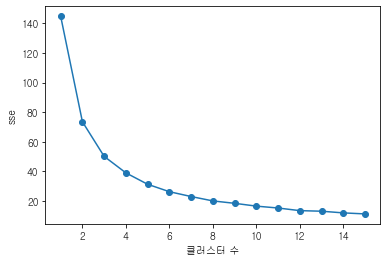

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

x = df_copy_scale[['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수']].values

## 방법 elbow기법

from sklearn.cluster import KMeans
init_centroid = "random" # 초기 클러스터 중심을 임의적
#init_centroid = "k-means++" # 기본값

def elbow(x):
    sse = [] #오차제곱합이 최소가 되도록 클러스터의 중심을 결정
    for i in range(1, 16):
        km = KMeans(n_clusters = i, init = "k-means++", random_state = 0)
        km.fit(x)
        sse.append(km.inertia_)
    plt.plot(range(1, 16), sse, marker = "o")
    plt.xlabel("클러스터 수")
    plt.ylabel("sse")
    plt.show()
    
elbow(x)

# k=3,4,5로실시

## K-means

In [10]:
#K-means 군집분석 실행
kmodel = KMeans(n_clusters = 3, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2','군집3'])
center.columns =['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수']

center

KMeans(init='random', n_clusters=3, random_state=0)
pred:  [1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 1 2 1 0 2 2 2 2 2 2 2 2 1 2 2 2 0 2 2 1 1 2
 2 2 2 1 2 2 1 0 2 1 1 1 1 1 0 2 2 2 2 1 1 2 2 2 1 1 1 2 1 0 1 1]


,청년인구,병원,경찰서,숙박시설,"법원, 교도소",초중고,청년인프라지수
군집1,0.427490,0.298146,0.400000,0.288312,0.100000,0.443820,8.189657
군집2,0.429745,0.462531,0.513021,0.221692,0.109375,0.498771,5.789833
군집3,0.284412,0.454071,0.382812,0.318689,0.171875,0.358497,4.118834


In [243]:
kmodel = KMeans(n_clusters = 4, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2','군집3','군집4'])
center.columns =['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수']

center

KMeans(init='random', n_clusters=4, random_state=0)
pred:  [1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 3 0 2 0 2 2 2 2 0 0 2 0 0 1 2 2 1 0 2
 0 2 2 0 2 0 1 3 2 1 1 0 1 1 1 2 2 2 2 0 1 0 2 0 1 1 1 2 1 3 1 1]


,청년인구,병원,경찰서,숙박시설,"법원, 교도소",초중고,청년인프라지수
군집1,0.440724,0.591795,0.496032,0.232529,0.130952,0.521937,4.851620
군집2,0.410756,0.409765,0.503205,0.218032,0.134615,0.464131,6.082631
군집3,0.194021,0.359053,0.320175,0.368421,0.171053,0.290065,3.755701
군집4,0.456396,0.306139,0.361111,0.393939,0.000000,0.370787,8.878291


array([[0.44072393, 0.59179469, 0.49603175, 0.23252938, 0.13095238,
        0.52193686, 4.85161965],
       [0.41075643, 0.40976514, 0.50320513, 0.21803197, 0.13461538,
        0.46413137, 6.0826315 ],
       [0.19402113, 0.35905276, 0.32017544, 0.36842105, 0.17105263,
        0.29006505, 3.75570122],
       [0.45639621, 0.30613927, 0.36111111, 0.39393939, 0.        ,
        0.37078652, 8.8782905 ]])

ValueError: 'c' argument has 28 elements, which is inconsistent with 'x' and 'y' with size 69.

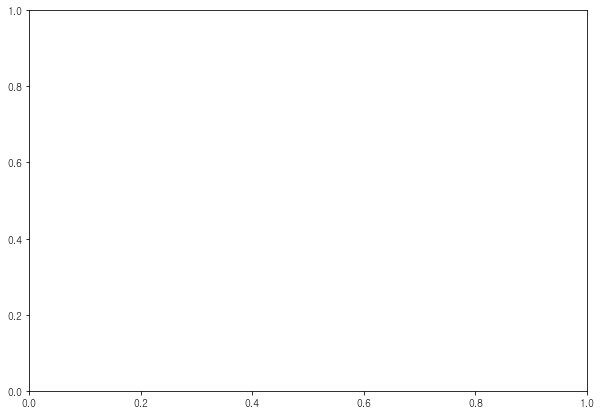

In [246]:
plt.figure(figsize=(10, 7))
plt.scatter(df_copy['청년인구'], df_copy['청년인프라지수'], cmap='rainbow')
plt.scatter(center['청년인구'],center['청년인프라지수'],c = 'k',s = 40)
plt.axhline(y=4, color='b', linewidth=1) #그래프에 직선그리기
plt.axhline(y=6, color='b', linewidth=1) #그래프에 직선그리기
plt.xlabel('청년인구')
plt.ylabel('인프라지수')

In [12]:
#분류된 군집에 따라 다른 색으로 지도에 표시
Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy_scale)):
    if pred[i]==0: 
        point = 'gray' #군집1 
    elif pred[i]== 1:
        point='blue'   #군집2
    elif pred[i]== 2:
        point='red'    #군집3
    elif pred[i]== 3: 
        point='purple '#군집4

    
    marker = g.Marker([df_copy_scale['lat'][i], df_copy_scale['lon'][i]], #위경도
                    tooltip = (df_copy_scale.index[i],
                               center.index[pred[i]], 
                               df_copy_scale['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map

<ipython-input-12-253eb4734e79>:19: UserWarning: color argument of Icon should be one of: {'pink', 'blue', 'lightgreen', 'purple', 'darkblue', 'darkred', 'red', 'black', 'lightblue', 'lightred', 'lightgray', 'orange', 'white', 'darkpurple', 'darkgreen', 'green', 'cadetblue', 'gray', 'beige'}.
  icon = g.Icon(color=point))


In [13]:
Map.save('인프라지수 K-means 군집분석 지도_2.html')

In [14]:
kmodel = KMeans(n_clusters = 5, init = init_centroid, random_state = 0)
print(kmodel)
pred = kmodel.fit_predict(x)
print("pred: ", pred)

center = pd.DataFrame(kmodel.cluster_centers_,
                     index = ['군집1','군집2','군집3','군집4','군집5'])
center.columns =['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수']

center

KMeans(init='random', n_clusters=5, random_state=0)
pred:  [4 4 4 3 4 4 3 4 3 3 4 3 3 4 4 4 3 4 0 3 1 2 2 2 2 2 3 3 2 3 2 4 2 2 4 3 1
 3 2 2 3 2 3 4 0 2 4 4 3 4 4 4 2 2 2 2 3 4 2 2 3 4 4 4 2 4 0 4 4]


,청년인구,병원,경찰서,숙박시설,"법원, 교도소",초중고,청년인프라지수
군집1,0.456396,0.306139,0.361111,0.393939,0.000000,0.370787,8.878291
군집2,0.031479,0.263288,0.208333,0.313312,0.000000,0.047753,1.920906
군집3,0.208498,0.350865,0.316667,0.353896,0.162500,0.312360,4.075360
군집4,0.483816,0.650323,0.541667,0.232143,0.152778,0.562734,4.882963
군집5,0.410756,0.409765,0.503205,0.218032,0.134615,0.464131,6.082631


## 계층적 군집분석

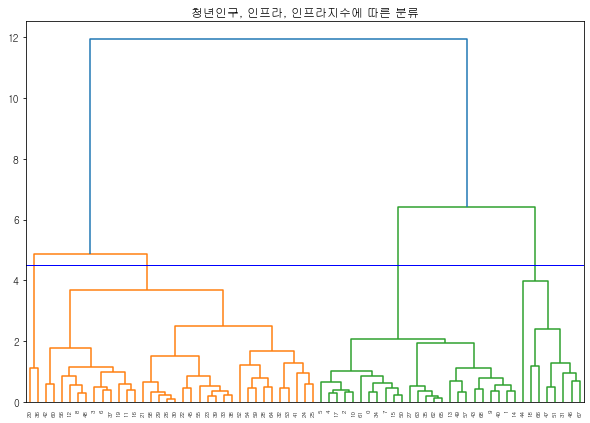

In [220]:
from scipy.cluster.hierarchy import dendrogram, linkage #계층적 군집분석시 필요
from matplotlib import pyplot as plt

#계층적 군집분석을 실행할 변수
df_Den = df_copy_scale.reindex(columns=['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수'])

linked = linkage(df_Den, 'single')

labelList = df_copy_scale.index


import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("청년인구, 인프라, 인프라지수에 따른 분류")
plt.axhline(y=4.5, color='b', linewidth=1) #그래프에 직선그리기
dend = shc.dendrogram(shc.linkage(df_Den, method='ward')) #덴도그램으로 시각화

In [16]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean() #0으로 예측된것들의 평균값을 저장
arr2 = df_Den[df_pred == 1].mean() #1으로 예측된것들의 평균값을 저장
arr3 = df_Den[df_pred == 2].mean() #2으로 예측된것들의 평균값을 저장

center = pd.DataFrame([arr1,arr2,arr3],
                     index = ['군집1','군집2','군집3'])

center

,청년인구,병원,경찰서,숙박시설,"법원, 교도소",초중고,청년인프라지수
군집1,0.315933,0.484377,0.412037,0.308983,0.166667,0.400749,4.220416
군집2,0.413055,0.315049,0.437500,0.344562,0.187500,0.466994,7.626403
군집3,0.412498,0.434561,0.493333,0.194156,0.080000,0.459551,5.803177


In [249]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_copy[df_pred == 0][['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수']].mean()
arr2 = df_copy[df_pred == 1][['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수']].mean()
arr3 = df_copy[df_pred == 2][['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수']].mean()
arr4 = df_copy[df_pred == 3][['청년인구','병원','경찰서','숙박시설','법원, 교도소','초중고','청년인프라지수']].mean()

arr1 = round(arr1, 2)

center = pd.DataFrame([arr1,arr2,arr3,arr4],
                     index = ['군집1','군집2','군집3','군집4'])

center

,청년인구,병원,경찰서,숙박시설,"법원, 교도소",초중고,청년인프라지수
군집1,69407.120000,341.880000,8.250000,123.120000,0.750000,97.120000,7.630000
군집2,57373.970588,489.382353,8.088235,112.088235,0.705882,89.029412,4.355682
군집3,69323.760000,438.560000,8.920000,76.800000,0.320000,95.800000,5.803177
군집4,12291.000000,300.000000,5.500000,113.500000,0.000000,22.500000,1.920906


Text(0, 0.5, '인프라지수')

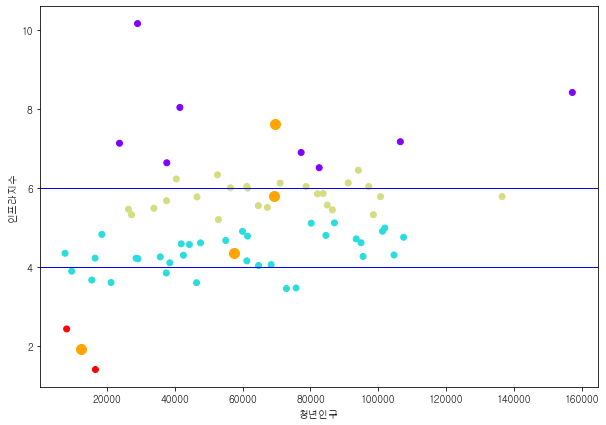

In [253]:
plt.figure(figsize=(10, 7))
plt.scatter(df_copy['청년인구'], df_copy['청년인프라지수'], c=cluster.labels_, cmap='rainbow')
plt.scatter(center['청년인구'],center['청년인프라지수'],c = 'orange',s = 100)
plt.axhline(y=4, color='b', linewidth=1) #그래프에 직선그리기
plt.axhline(y=6, color='b', linewidth=1) #그래프에 직선그리기
plt.xlabel('청년인구')
plt.ylabel('인프라지수')

df_copy[df_pred == 3].to_csv('군집4.csv', encoding="cp949")
df_copy[df_pred == 1].to_csv('군집2.csv', encoding="cp949")

In [62]:
# 청년 인구 유출이 심한 시군구
df_low_adult = df_copy.loc[['인천_강화군',
                            '대구_서구','대구_수성구','부산_영도구','부산_사하구','부산_금정구','부산_서구',
                            '부산_사상구','울산_동구','대전_대덕구']]
df_low_adult['군집'] = (None,'군집2','군집2','군집2','군집2','군집2','군집2','군집3','군집3','군집3')
df_low_adult.reset_index(drop=False, inplace = True)
df_low_adult.set_index(['군집','시군구'], inplace = True)

df_low_adult = df_low_adult.drop(['lat','lon'], axis = 1)
df_low_adult[['청년인구','청년인프라지수']]

청년인구   청년인프라지수
군집  시군구                      
NaN 인천_강화군   7579.0  4.350970
군집2 대구_서구   29105.0  4.212656
    대구_수성구  72909.0  3.458098
    부산_영도구  16436.0  4.227702
    부산_사하구  54995.0  4.674851
    부산_금정구  44260.0  4.572486
    부산_서구   18425.0  4.828268
군집3 부산_사상구  40407.0  6.233003
    울산_동구   26280.0  5.464600
    대전_대덕구  33792.0  5.489834

In [225]:
Map = g.Map(location=[36.427680, 127.936191], zoom_start=7) #지도 시작 위치

for i in range(len(df_copy_scale)):
    if df_pred[i]== 0: 
        point = 'purple'   #군집1
    elif df_pred[i]== 1:
        point='blue'       #군집2
    elif df_pred[i]== 2:
        point='lightgreen' #군집3
    elif df_pred[i]== 3:
        point='red'        #군집4
    
    marker = g.Marker([df_copy_scale['lat'][i], df_copy_scale['lon'][i]], #위경도
                    tooltip = (df_copy_scale.index[i],
                               center.index[df_pred[i]], 
                               df_copy_scale['청년인프라지수'][i]),
                    icon = g.Icon(color=point)) 
    marker.add_to(Map)
    
Map

In [226]:
Map.save('인프라지수 계층적 군집분석 지도_2_수정.html')

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
df_pred = cluster.fit_predict(df_Den)

arr1 = df_Den[df_pred == 0].mean()
arr2 = df_Den[df_pred == 1].mean()
arr3 = df_Den[df_pred == 2].mean()
arr4 = df_Den[df_pred == 3].mean()
arr5 = df_Den[df_pred == 4].mean()

center = pd.DataFrame([arr1,arr2,arr3,arr4,arr5],
                     index = ['군집1','군집2','군집3','군집4','군집5'])

center

In [79]:
df_group_copy = df_copy.copy()

df_group_copy['군집'] = ''

for i in range(len(df_copy)):
    if df_pred[i]== 0: 
        df_group_copy.iloc[i,-1] = '군집1'
    elif df_pred[i]== 1:
        df_group_copy.iloc[i,-1] = '군집2'
    elif df_pred[i]== 2:
        df_group_copy.iloc[i,-1] = '군집3'
    elif df_pred[i]== 3:
        df_group_copy.iloc[i,-1] = '군집4'
        
df_group_copy.reset_index(drop=False, inplace=True)
df_group_copy.set_index(['군집','시군구'],
                 drop = True, inplace=True)

In [80]:
df_group_copy

청년인구   병원  사회스포츠  대학교    초중고  공항  소방서  경찰서  \
군집  시군구                                                      
군집3 서울_용산구   52554.0  319   19.0    1   47.0   0    1    9   
    서울_성동구   67271.0  457   21.0    2   69.0   0    1   10   
    서울_광진구   91126.0  558   76.0    3   76.0   0    1   12   
군집2 서울_동대문구  80217.0  597   43.0    4   76.0   0    1   12   
군집3 서울_중랑구   83722.0  539   96.0    1   76.0   0    1    9   
...              ...  ...    ...  ...    ...  ..  ...  ...   
군집2 울산_남구    64670.0  618   24.0    1  106.0   0    1    6   
군집3 울산_동구    26280.0  174   18.0    1   60.0   0    1    5   
군집1 울산_북구    41455.0  172   30.0    0   94.0   1    1    5   
    울산_울주군   37605.0  206   57.0    2  107.0   0    1   11   
군집3 세종시      64602.0  402   47.0    3  155.0   0    2   11   

             소형상업시설(음식점_카페_학원_편의점)  대형상업시설  숙박시설  기차역  행정기관  법원, 교도소  \
군집  시군구                                                                
군집3 서울_용산구                    5056      23   104    9  18.0      1.0   
    서울_성동구                    4562      22    62    3  19.0      0.0   
    서울_광진구                    5609      26    66    0  17.0      0.0   
군집2 서울_동대문구                   4902      33   112    7  16.0      0.0   
군집3 서울_중랑구                    4410      14    89    7  18.0      0.0   
...                            ...     ...   ...  ...   ...      ...   
군집2 울산_남구                     7460      16   244    4  16.0      2.0   
군집3 울산_동구                     3107       3    71    0  10.0      0.0   
군집1 울산_북구                     3492      11    52    2   9.0      0.0   
    울산_울주군                    4586       5   195    5  13.0      1.0   
군집3 세종시                       5922      10    61    8  21.0      1.0   

             문화시설_영화/공연/미술관박물관  버스터미널   청년인프라지수       id        lat  \
군집  시군구                                                               
군집3 서울_용산구                48.0    0.0  6.336887  11170.0  37.531386   
    서울_성동구                31.0    0.0  5.511858  11200.0  37.551030   
    서울_광진구                25.0    1.0  6.133916  11215.0  37.546722   
군집2 서울_동대문구               21.0    0.0  5.112107  11230.0  37.581957   
군집3 서울_중랑구                 5.0    1.0  5.865862  11260.0  37.597819   
...                        ...    ...       ...      ...        ...   
군집2 울산_남구                 18.0    3.0  4.040873  31140.0  35.516052   
군집3 울산_동구                  4.0    0.0  5.464600  31170.0  35.525580   
군집1 울산_북구                  9.0    0.0  8.043699  31200.0  35.610062   
    울산_울주군                18.0    1.0  6.642159  31710.0  35.546697   
군집3 세종시                   26.0    3.0  5.556882  36110.0  36.560729   

                    lon  
군집  시군구                  
군집3 서울_용산구   126.979908  
    서울_성동구   127.041059  
    서울_광진구   127.085746  
군집2 서울_동대문구  127.054848  
군집3 서울_중랑구   127.092884  
...                 ...  
군집2 울산_남구    129.328190  
군집3 울산_동구    129.426070  
군집1 울산_북구    129.379802  
    울산_울주군   129.186826  
군집3 세종시      127.258722  

[69 rows x 20 columns]

In [188]:
df_num = df_group_copy.sort_values(by=['청년인프라지수'],
                   axis = 0,
                   ascending = True,
                   inplace = False)

#df_num.reset_index(drop=False, inplace=True)
#df_num.set_index('시군구',
#                 drop = True, inplace=True)
#df_num['총 인프라 갯수'] = df_num['병원']+df_num['사회스포츠']+df_num['대학교']+df_num['초중고']+df_num['공항']+df_num['소방서']+df_num['경찰서']+df_num['소형상업시설(음식점_카페_학원_편의점)']+df_num['대형상업시설']+df_num['숙박시설']+df_num['기차역']+df_num['행정기관']+df_num['법원, 교도소']+df_num['문화시설_영화/공연/미술관박물관']+df_num['버스터미널']
#df_num['인프라가 수용하는 청년인구수'] = df_num['청년인구']/df_num['총 인프라 갯수']

df_num = df_num.loc[(df_num['청년인프라지수']),:] #청년인프라지수 <= 4.5

df_num = df_num.loc[:,['청년인구','병원','초중고','경찰서','숙박시설','법원, 교도소','청년인프라지수']]

df_num

#x_standard = df_num['청년인구'] / 10000  #청년인구를 10000으로 나눠서 보정
#x_standard.reset_index(drop=True, inplace=True)

#x_standard = np.array(x_standard)

#df_num_value = df_num[['병원','초중고','경찰서','숙박시설','법원, 교도소']]

#df_standard = df_num_value.T / x_standard
#df_standard.T

청년인구   병원    초중고  경찰서  숙박시설  법원, 교도소   청년인프라지수
군집  시군구                                                        
군집4 대구_중구     16533.0  460   31.0    5   102      0.0  1.407263
    부산_중구      8049.0  140   14.0    6   125      0.0  2.434548
군집2 대구_수성구    72909.0  786  122.0    9    72      3.0  3.458098
    부산_진구     75731.0  832  111.0   10   178      0.0  3.472788
    부산_동래구    46382.0  488   80.0    7   126      0.0  3.605899
    광주_동구     21164.0  231   40.0    6   128      2.0  3.609981
    부산_동구     15455.0  170   27.0    6   123      0.0  3.673136
    부산_연제구    37451.0  369   47.0    6    54      3.0  3.851901
    인천_동구      9546.0   90   27.0    3    37      0.0  3.897036
    울산_남구     64670.0  618  106.0    6   244      2.0  4.040873
    부산_해운대구   68385.0  662  102.0   10   325      1.0  4.062954
    광주_남구     38492.0  331  101.0    7    35      0.0  4.109617
    광주_서구     61222.0  553  108.0    8   147      1.0  4.158870
    대구_서구     29105.0  262   53.0    6    97      0.0  4.212656
    대구_남구     28526.0  251   44.0    6    37      0.0  4.223507
    부산_영도구    16436.0  142   41.0    5    48      0.0  4.227702
    부산_수영구    35665.0  326   41.0    4   111      0.0  4.259112
    서울_강동구    95519.0  844   97.0   10    70      0.0  4.271018
    대전_중구     42500.0  374   96.0    6   185      0.0  4.301411
    대전_서구    104642.0  896  165.0   11    79      4.0  4.307267
    인천_강화군     7579.0   87   56.0   14   305      1.0  4.350970

In [217]:
df_num = df_group_copy.sort_values(by=['시군구'],
                   axis = 0,
                   ascending = True,
                   inplace = False)

df_num = df_num.loc[:,['청년인구','청년인프라지수']]

df_num.loc['군집2',:].head(17)

,청년인구,청년인프라지수
시군구,,
광주_남구,38492.0,4.109617
광주_동구,21164.0,3.609981
광주_북구,87062.0,5.120784
광주_서구,61222.0,4.158870
대구_남구,28526.0,4.223507
대구_달서구,107479.0,4.757259
대구_동구,61421.0,4.786209
대구_서구,29105.0,4.212656
대구_수성구,72909.0,3.458098


In [218]:
df_num.loc['군집3',:]

,청년인구,청년인프라지수
시군구,,
광주_광산구,82059.0,5.856938
대구_달성군,46508.0,5.778112
대구_북구,86446.0,5.448835
대전_대덕구,33792.0,5.489834
대전_유성구,78707.0,6.040362
부산_기장군,27182.0,5.326058
부산_북구,52833.0,5.203974
부산_사상구,40407.0,6.233003
서울_강서구,136535.0,5.787887


In [186]:
df_mean = df_group_copy.sort_values(by=['청년인프라지수'],
                   axis = 0,
                   ascending = True,
                   inplace = False)

df_mean = df_mean.loc[(df_mean['청년인프라지수'] >= 4.5)&(df_mean['청년인프라지수'] <= 5.5),:] #평균에 위치하는 시군구

df_mean = df_mean.loc[:,['청년인구','병원','초중고','경찰서','숙박시설','법원, 교도소','청년인프라지수']]

df_mean['청년인구'].mean()

#x_standard =df_mean_2['청년인구'] / 10000
#df_mean_standard = df_mean_2[1:6] / x_standard
#df_mean_standard

66877.85714285714

In [185]:
df_num = df_group_copy.sort_values(by=['청년인프라지수'],
                   axis = 0,
                   ascending = True,
                   inplace = False)

df_num.reset_index(drop=False, inplace=True)
df_num.set_index('시군구',
                 drop = True, inplace=True)
#df_num['총 인프라 갯수'] = df_num['병원']+df_num['사회스포츠']+df_num['대학교']+df_num['초중고']+df_num['공항']+df_num['소방서']+df_num['경찰서']+df_num['소형상업시설(음식점_카페_학원_편의점)']+df_num['대형상업시설']+df_num['숙박시설']+df_num['기차역']+df_num['행정기관']+df_num['법원, 교도소']+df_num['문화시설_영화/공연/미술관박물관']+df_num['버스터미널']
#df_num['인프라가 수용하는 청년인구수'] = df_num['청년인구']/df_num['총 인프라 갯수']

df_num = df_num.loc[(df_num['청년인프라지수'] >= 5.5),:] #청년인프라지수 <= 4.5

df_num = df_num.loc[:,['청년인구','병원','초중고','경찰서','숙박시설','법원, 교도소','청년인프라지수']]


x_standard = df_num['청년인구'] / 10000  #청년인구를 10000으로 나눠서 보정
x_standard.reset_index(drop=True, inplace=True)

x_standard = np.array(x_standard)

df_num_value = df_num[['병원','초중고','경찰서','숙박시설','법원, 교도소']]

df_standard = df_num_value.T / x_standard
df_standard.T

,병원,초중고,경찰서,숙박시설,"법원, 교도소"
시군구,,,,,
서울_성동구,67.934177,10.257020,1.486525,9.216453,0.000000
세종시,62.227176,23.993065,1.702734,9.442432,0.154794
서울_구로구,67.562000,10.475641,1.059335,11.770383,0.117704
울산_중구,63.424384,20.786143,1.865423,21.052632,0.000000
대구_달성군,60.419713,22.146727,2.580201,11.825922,0.215017
인천_부평구,63.092423,15.201796,1.291656,11.624903,0.000000
서울_강서구,64.452338,9.960816,0.805654,6.738199,0.000000
광주_광산구,59.591270,21.813573,1.827953,10.967718,0.000000
서울_중랑구,64.379733,9.077662,1.074986,10.630420,0.000000


In [82]:
df_adult = df_group_copy.sort_values(by=['청년인구'],
                   axis = 0,
                   ascending = True,
                   inplace = False)

df_adult = df_adult.iloc[:10] # 청년인구 기준 하위 10개 도시
df_adult = df_adult.loc[:,['청년인구','청년인프라지수']]

df_adult

청년인구   청년인프라지수
군집  시군구                      
군집2 인천_강화군   7579.0  4.350970
군집4 부산_중구    8049.0  2.434548
군집2 인천_동구    9546.0  3.897036
    부산_동구   15455.0  3.673136
    부산_영도구  16436.0  4.227702
군집4 대구_중구   16533.0  1.407263
군집2 부산_서구   18425.0  4.828268
    광주_동구   21164.0  3.609981
군집1 부산_강서구  23640.0  7.137549
군집3 울산_동구   26280.0  5.464600